# Intro to Random Forests

## Imports

In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
from fastai.imports import *
#from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from fastai.tabular import *
from fastai.collab import *
from IPython.display import HTML
from sklearn.preprocessing import LabelEncoder

In [68]:
PATH = "../input"
!ls {PATH}
path = '../working'
!ls {path}

X_test.csv  X_train.csv  sample_submission.csv	y_train.csv
__notebook_source__.ipynb  models


In [69]:
df_raw = pd.read_csv(f'{PATH}/X_train.csv', low_memory=False)
y_raw = pd.read_csv(f'{PATH}/y_train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}/X_test.csv', low_memory=False)
sub = pd.read_csv(f'{PATH}/sample_submission.csv')

In [70]:
df_raw.shape,df_test.shape,y_raw.shape

((487680, 13), (488448, 13), (3810, 3))

In [71]:
df_raw[df_raw.isnull().any(axis=1)]

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z


In [72]:
y_raw[y_raw.isnull().any(axis=1)]

,series_id,group_id,surface


In [73]:
df_test[df_test.isnull().any(axis=1)]

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z


In [74]:
sub.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [75]:
le = LabelEncoder()
le.fit(y_raw['surface'])
y_raw['surface'] = le.transform(y_raw['surface'])

In [76]:
#FE from https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe(df):
    df['total_angular_velocity'] = (df['angular_velocity_X'] ** 2 + df['angular_velocity_Y'] ** 2 + df['angular_velocity_Z'] ** 2) ** 0.5
    df['total_linear_acceleration'] = (df['linear_acceleration_X'] ** 2 + df['linear_acceleration_Y'] ** 2 + df['linear_acceleration_Z'] ** 2) ** 0.5
    df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 +df['orientation_Z'])**0.5
    
    df['acc_vs_vel'] = df['total_linear_acceleration'] / df['total_angular_velocity']
    
    
    temp_df = pd.DataFrame()
    for col in df.columns[3:]:
        temp_df[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        temp_df[col + '_median'] = df.groupby(['series_id'])[col].median()
        temp_df[col + '_max'] = df.groupby(['series_id'])[col].max()
        temp_df[col + '_min'] = df.groupby(['series_id'])[col].min()
        temp_df[col + '_std'] = df.groupby(['series_id'])[col].std()
        temp_df[col + '_range'] = temp_df[col + '_max'] - temp_df[col + '_min']
        temp_df[col + '_maxtoMin'] = temp_df[col + '_max'] / temp_df[col + '_min']
        temp_df[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        temp_df[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        temp_df[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        temp_df[col + '_abs_avg'] = (temp_df[col + '_abs_min'] + temp_df[col + '_abs_max'])/2
    return temp_df

In [77]:
%%time
df_train = fe(df_raw)
df_test = fe(df_test)

CPU times: user 55.1 s, sys: 160 ms, total: 55.3 s
Wall time: 55 s


In [78]:
df_train.shape, df_test.shape,y_raw.shape

((3810, 154), (3816, 154), (3810, 3))

In [79]:
df_train.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_min,orientation_Y_abs_max,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_min,orientation_Z_abs_max,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,...,total_angular_velocity_std,total_angular_velocity_range,total_angular_velocity_maxtoMin,total_angular_velocity_mean_abs_chg,total_angular_velocity_abs_min,total_angular_velocity_abs_max,total_angular_velocity_abs_avg,total_linear_acceleration_mean,total_linear_acceleration_median,total_linear_acceleration_max,total_linear_acceleration_min,total_linear_acceleration_std,total_linear_acceleration_range,total_linear_acceleration_maxtoMin,total_linear_acceleration_mean_abs_chg,total_linear_acceleration_abs_min,total_linear_acceleration_abs_max,total_linear_acceleration_abs_avg,total_xyz_mean,total_xyz_median,total_xyz_max,total_xyz_min,total_xyz_std,total_xyz_range,total_xyz_maxtoMin,total_xyz_mean_abs_chg,total_xyz_abs_min,total_xyz_abs_max,total_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,0.75822,0.75953,0.758875,-0.634008,-0.634270,-0.63306,-0.63456,0.000471,0.00150,0.997636,0.000018,0.63306,0.63456,0.633810,-0.105474,-0.105500,-0.104610,-0.106140,0.000432,0.001530,0.985585,0.000051,0.104610,0.106140,0.105375,-0.106470,-0.106555,-0.105590,-0.107050,0.000389,0.001460,0.986362,...,0.028263,0.151781,15.314654,0.024643,0.010603,0.162384,0.086494,9.939676,10.077860,12.575577,7.117152,0.989642,5.458424,1.766939,0.689030,7.117152,12.575577,9.846364,0.933845,0.933813,0.934380,0.933377,0.000304,0.001003,1.001075,0.000036,0.933377,0.934380,0.933879,223.282937,187.471573,995.561076,56.133014,135.641510,939.428062,17.735749,114.896199,56.133014,995.561076,525.847045
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,0.95837,0.95896,0.958665,0.241867,0.241890,0.24270,0.24074,0.000499,0.00196,1.008142,0.000070,0.24074,0.24270,0.241720,0.031650,0.031688,0.032341,0.030504,0.000508,0.001837,1.060222,0.000048,0.030504,0.032341,0.031423,-0.146876,-0.146910,-0.145870,-0.148090,0.000521,0.002220,0.985009,...,0.052645,0.267779,14.277849,0.041180,0.020167,0.287947,0.154057,10.082444,10.069950,16.986332,5.867993,1.826016,11.118339,2.894743,1.361058,5.867993,16.986332,11.427163,1.004528,1.004494,1.004888,1.004061,0.000228,0.000828,1.000824,0.000023,1.004061,1.004888,1.004474,118.973908,98.477877,611.826712,32.938319,88.488750,578.888393,18.574922,57.943094,32.938319,611.826712,322.382516
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.50944,0.51434,0.511890,-0.846171,-0.846210,-0.84490,-0.84779,0.000785,0.00289,0.996591,0.000024,0.84490,0.84779,0.846345,-0.129371,-0.129405,-0.128520,-0.130300,0.000541,0.001780,0.986339,0.000059,0.128520,0.130300,0.129410,-0.071082,-0.071139,-0.070378,-0.071535,0.000278,0.001157,0.983826,...,0.033906,0.161048,17.314963,0.023495,0.009871,0.170919,0.090395,10.035741,10.082289,12.725500,6.794325,0.944637,5.931175,1.872960,0.711678,6.794325,12.725500,9.759913,0.921325,0.921301,0.921914,0.920665,0.000378,0.001249,1.001356,0.000042,0.

In [80]:
y_raw.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


In [81]:
df_train['surface'] = y_raw['surface']

In [82]:
df_test.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_min,orientation_Y_abs_max,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_min,orientation_Z_abs_max,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,...,total_angular_velocity_std,total_angular_velocity_range,total_angular_velocity_maxtoMin,total_angular_velocity_mean_abs_chg,total_angular_velocity_abs_min,total_angular_velocity_abs_max,total_angular_velocity_abs_avg,total_linear_acceleration_mean,total_linear_acceleration_median,total_linear_acceleration_max,total_linear_acceleration_min,total_linear_acceleration_std,total_linear_acceleration_range,total_linear_acceleration_maxtoMin,total_linear_acceleration_mean_abs_chg,total_linear_acceleration_abs_min,total_linear_acceleration_abs_max,total_linear_acceleration_abs_avg,total_xyz_mean,total_xyz_median,total_xyz_max,total_xyz_min,total_xyz_std,total_xyz_range,total_xyz_maxtoMin,total_xyz_mean_abs_chg,total_xyz_abs_min,total_xyz_abs_max,total_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.025810,-0.025748,-0.025156,-0.026418,0.000284,0.001262,0.952230,0.000055,0.025156,0.026418,0.025787,-0.988644,-0.988645,-0.98854,-0.98873,0.000039,0.00019,0.999808,0.000015,0.98854,0.98873,0.988635,-0.148006,-0.148010,-0.147480,-0.148720,0.000253,0.00124,0.991662,0.000105,0.147480,0.148720,0.148100,0.003147,0.003134,0.003609,0.002654,0.000233,0.000955,1.359810,...,0.039837,0.221576,21.513522,0.039292,0.010801,0.232378,0.121590,9.988501,9.937717,16.613628,6.133113,1.907297,10.480515,2.708841,1.534203,6.133113,16.613628,11.373370,0.911086,0.911082,0.911460,0.910583,0.000180,0.000877,1.000963,0.000074,0.910583,0.911460,0.911022,125.946166,103.231038,902.410168,37.998811,98.622296,864.411357,23.748379,69.077232,37.998811,902.410168,470.204490
1,-0.932288,-0.932115,-0.931480,-0.933720,0.000564,0.002240,0.997601,0.000021,0.931480,0.933720,0.932600,0.330271,0.330815,0.33227,0.32661,0.001654,0.00566,1.017330,0.000050,0.32661,0.33227,0.329440,0.043416,0.043395,0.044053,0.042283,0.000326,0.00177,1.041861,0.000039,0.042283,0.044053,0.043168,-0.140968,-0.141070,-0.139940,-0.141790,0.000601,0.001850,0.986953,...,0.048464,0.279794,27.971609,0.024851,0.010374,0.290167,0.150271,10.039059,9.967605,13.438388,4.023689,1.157338,9.414698,3.339817,0.684772,4.023689,13.438388,8.731039,1.010771,1.010779,1.010987,1.010342,0.000143,0.000645,1.000639,0.000014,1.010342,1.010987,1.010664,157.725288,130.131276,949.323991,20.871618,128.164165,928.452374,45.483968,62.630171,20.871618,949.323991,485.097805
2,-0.230186,-0.230600,-0.227130,-0.231410,0.001054,0.004280,0.981505,0.000093,0.227130,0.231410,0.229270,0.961448,0.961360,0.96217,0.96109,0.000260,0.00108,1.001124,0.000030,0.96109,0.96217,0.961630,0.144340,0.144395,0.145110,0.143560,0.000335,0.00155,1.010797,0.000115,0.143560,0.145110,0.144335,-0.042394,-0.042506,-0.041394,-0.042938,0.000363,0.001544,0.964041,...,0.063919,0.299943,12.049258,0.050656,0.027146,0.327088,0.177117,10.425586,10.231940,16.713460,5.497468,2.331304,11.215992,3.040210,1.761510,5.497468,16.713460,11.105464,1.059107,1.059115,1.059356,1.058854,0.000109,0.000502,1.000474,0.000037,1.

In [83]:
#df_raw , test1 = df_raw.drop(['measurement_number','row_id'],axis=1), df_test.drop(['measurement_number','row_id'],axis=1)

## The data

### Look at the data

In [84]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [122]:
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [86]:
#display_all(df_test.describe(include='all'))

### Initial processing

In [87]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(df_train.surface, pred)
# cm

In [88]:
df, y = df_train.drop('surface',axis=1), df_train.surface

In [89]:
# def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# n_valid = 800  
# n_trn = len(df)-n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
# X_train, X_valid = split_vals(df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

# X_train.shape, y_train.shape, X_valid.shape

In [90]:
# train_series_id, valid_series_id = X_train.series_id, X_valid.series_id

In [91]:
# X_train, X_valid = X_train.drop(['series_id'],axis=1), X_valid.drop(['series_id'],axis=1)

In [92]:
# X_test = df_test.drop(['series_id'],axis=1)

In [93]:
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape

## Base model

In [94]:
#def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [ m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [95]:
# train_seriesid = df_train['series_id']
# df_train = df_train.drop(['series_id'],axis=1)

In [96]:
# test_seriesid = df_test['series_id']
# df_test = df_test.drop(['series_id'],axis=1)

In [97]:
# df_train.shape,df_test.shape

In [98]:
dep_var = 'surface'
cont_vars = list(df_test.columns)
procs = [FillMissing]

In [99]:
data = (TabularList.from_df(df_train, path=path, cont_names=cont_vars, procs=procs,)
                .split_by_idx(list(range(3801,3810)))
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(df_test, path=path, cont_names=cont_vars))
                .databunch())

In [100]:
data.show_batch(rows=5)


orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,orientation_Y_median,orientation_Y_max,orientation_Y_min,orientation_Y_std,orientation_Y_range,orientation_Y_maxtoMin,orientation_Y_mean_abs_chg,orientation_Y_abs_min,orientation_Y_abs_max,orientation_Y_abs_avg,orientation_Z_mean,orientation_Z_median,orientation_Z_max,orientation_Z_min,orientation_Z_std,orientation_Z_range,orientation_Z_maxtoMin,orientation_Z_mean_abs_chg,orientation_Z_abs_min,orientation_Z_abs_max,orientation_Z_abs_avg,orientation_W_mean,orientation_W_median,orientation_W_max,orientation_W_min,orientation_W_std,orientation_W_range,orientation_W_maxtoMin,orientation_W_mean_abs_chg,orientation_W_abs_min,orientation_W_abs_max,orientation_W_abs_avg,angular_velocity_X_mean,angular_velocity_X_median,angular_velocity_X_max,angular_velocity_X_min,angular_velocity_X_std,angular_velocity_X_range,angular_velocity_X_maxtoMin,angular_velocity_X_mean_abs_chg,angular_velocity_X_abs_min,angular_velocity_X_abs_max,angular_velocity_X_abs_avg,angular_velocity_Y_mean,angular_velocity_Y_median,angular_velocity_Y_max,angular_velocity_Y_min,angular_velocity_Y_std,angular_velocity_Y_range,angular_velocity_Y_maxtoMin,angular_velocity_Y_mean_abs_chg,angular_velocity_Y_abs_min,angular_velocity_Y_abs_max,angular_velocity_Y_abs_avg,angular_velocity_Z_mean,angular_velocity_Z_median,angular_velocity_Z_max,angular_velocity_Z_min,angular_velocity_Z_std,angular_velocity_Z_range,angular_velocity_Z_maxtoMin,angular_velocity_Z_mean_abs_chg,angular_velocity_Z_abs_min,angular_velocity_Z_abs_max,angular_velocity_Z_abs_avg,linear_acceleration_X_mean,linear_acceleration_X_median,linear_acceleration_X_max,linear_acceleration_X_min,linear_acceleration_X_std,linear_acceleration_X_range,linear_acceleration_X_maxtoMin,linear_acceleration_X_mean_abs_chg,linear_acceleration_X_abs_min,linear_acceleration_X_abs_max,linear_acceleration_X_abs_avg,linear_acceleration_Y_mean,linear_acceleration_Y_median,linear_acceleration_Y_max,linear_acceleration_Y_min,linear_acceleration_Y_std,linear_acceleration_Y_range,linear_acceleration_Y_maxtoMin,linear_acceleration_Y_mean_abs_chg,linear_acceleration_Y_abs_min,linear_acceleration_Y_abs_max,linear_acceleration_Y_abs_avg,linear_acceleration_Z_mean,linear_acceleration_Z_median,linear_acceleration_Z_max,linear_acceleration_Z_min,linear_acceleration_Z_std,linear_acceleration_Z_range,linear_acceleration_Z_maxtoMin,linear_acceleration_Z_mean_abs_chg,linear_acceleration_Z_abs_min,linear_acceleration_Z_abs_max,linear_acceleration_Z_abs_avg,total_angular_velocity_mean,total_angular_velocity_median,total_angular_velocity_max,total_angular_velocity_min,total_angular_velocity_std,total_angular_velocity_range,total_angular_velocity_maxtoMin,total_angular_velocity_mean_abs_chg,total_angular_velocity_abs_min,total_angular_velocity_abs_max,total_angular_velocity_abs_avg,total_linear_acceleration_mean,total_linear_acceleration_median,total_linear_acceleration_max,total_linear_acceleration_min,total_linear_acceleration_std,total_linear_acceleration_range,total_linear_acceleration_maxtoMin,total_linear_acceleration_mean_abs_chg,total_linear_acceleration_abs_min,total_linear_acceleration_abs_max,total_linear_acceleration_abs_avg,total_xyz_mean,total_xyz_median,total_xyz_max,total_xyz_min,total_xyz_std,total_xyz_range,total_xyz_maxtoMin,total_xyz_mean_abs_chg,total_xyz_abs_min,total_xyz_abs_max,total_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg,target
0.6229,0.6229,0.6299,0.6161,0.0041,0.0138,1.0224,0.0001,0.6161,0.6299,0.6230,-0.7734,-0.7735,-0.7670,-0.7792,0.0035,0.0122,0.9843,0.0001,0.7670,0.7792,0.7731,-0.0860,-0.0861,-0.0839,-0.0884,

In [101]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.005,0.05], emb_drop=0.08, 
                         metrics=accuracy)

In [102]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.08)
  (bn_cont): BatchNorm1d(154, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=154, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.005)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05)
    (8): Linear(in_features=500, out_features=9, bias=True)
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


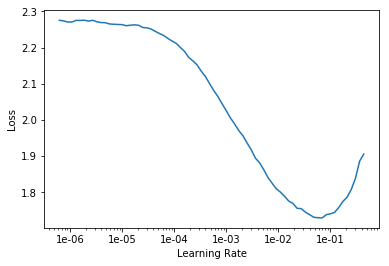

In [103]:
learn.lr_find()
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(5, 2e-3, wd=0.06)

epoch,train_loss,valid_loss,accuracy,time
0,1.413953,1.119845,0.631068,00:01
1,1.100829,0.907899,0.663430,00:01
2,0.869702,0.829199,0.676375,00:01
3,0.686440,0.579849,0.805825,00:01
4,0.543482,0.542038,0.828479,00:01


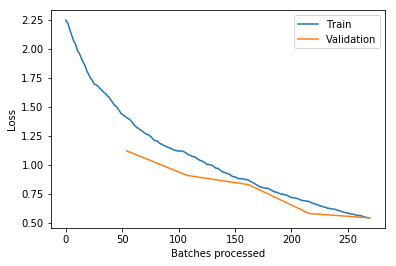

In [105]:
learn.recorder.plot_losses()

In [106]:
learn.fit_one_cycle(6, 2e-3,wd=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.479056,0.568122,0.812298,00:01
1,0.588148,0.648690,0.779935,00:01
2,0.599890,0.706359,0.731392,00:01
3,0.516775,0.477132,0.825243,00:01
4,0.405845,0.464185,0.854369,00:01
5,0.323622,0.440034,0.841424,00:01


In [107]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


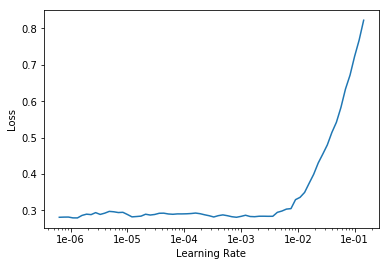

In [108]:
learn.lr_find()
learn.recorder.plot()

In [109]:
learn.fit_one_cycle(10, 1e-7,wd=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.265704,0.476605,0.834951,00:01
1,0.276484,0.466858,0.838188,00:01
2,0.269408,0.439710,0.841424,00:01
3,0.274576,0.452099,0.841424,00:01
4,0.277826,0.440063,0.834951,00:01
5,0.280211,0.440083,0.838188,00:01
6,0.270708,0.451438,0.838188,00:01
7,0.269599,0.452161,0.831715,00:01
8,0.276757,0.432550,0.841424,00:01
9,0.276567,0.449918,0.844660,00:01


In [ ]:
test_preds = learn.get_preds(DatasetType.Test)[1]
submit1 = pd.concat([test_seriesid,pd.Series(test_preds)],axis=1)
submit1.columns =['series_id','surface']
#submit1['surface'].map(map)

In [111]:
learn.get_preds(DatasetType.Test)[0]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [120]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = le.inverse_transform(np.array([np.argmax(preds[i]) for i in range(len(preds))]))
sub['surface'] = labelled_preds

In [121]:
sub.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_tiles


In [125]:
sub.to_csv('submission.csv',index=False)
create_download_link(filename='submission.csv')